# Solving Ordinary Differential Equations 
# Session 8 Part 1: Boundary Value Problems using Banded Matrices

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

import scipy.integrate as integrate

---
<img src="http://slideplayer.com/slide/1474150/4/images/3/Daniel+Baur+/+Numerical+Methods+for+Chemical+Engineers+/+BVP+and+PDE.jpg" align="RIGHT" width="50%">


# Last week review: 

## Solution 1: The Shooting Method 

- Use `odeint` to solve 1st order or coupled odes
- Use optimisation to match the far BC
- Can even work for non-linear problems
- But it is iterative so can be slow


---

# SOLUTION 2: Banded matrices

- If the problem is linear -- i.e. you can write it as a matrix vector equation then you should do this.
- Even if you can't directly solve it might be possible to linearize your equations to give you a good first estimate.   

The entire idea here is to discretise the ordinary differential equation into a set of many simultaneous equations which can be described as a matrix problem:

$$\mathbf{M}\mathbf{y}=\mathbf{a}$$

Where,
- $\mathbf{M}$ is the banded matrix that describes the derivatives
- $\mathbf{y}$ is the solution we want to solve for
- $\mathbf{a}$ is the RHS of the differential equation

This can the be solved for $y$ using `linalg.solve`.

## We need to know how to solve simultaneous equaions 

Lets look at how to solve martix equations of the form $\mathbf{M}\mathbf{y}=\mathbf{a}$

#  ASSIDE: Click on the link to the [Solving Matrices notebook](Session 8 Linear Algebra - Solving the Matrix Equation Ax=b in Python.ipynb)


Now you know how to solve these matrix equations - let's look at how this can help us these methods solve boundary value ODEs.
- The key is to construct a set of simultaneous equations that we can solve with `linalg.solve`
- These simultaneous equations tell us how the value at a given node is related to the values of adjacent nodes and any forcing terms that might be applied.
- We will work with and example.

# 1. What is the relation between an ODE, simultaneous equations and a banded martix?

If you can answer the question above - you are a long way to understanding how this works.

Let's try to answer this question to build you intuition by condidering the discretisation below.

Consider how we will discretise: $$\frac{d^2y}{dx^2} = \sin (x) $$.

Below we show visually how this can be written as a matrix problem $\mathbf{M}\mathbf{y}=\mathbf{a}$.

<img src="Slide1.png" width="80%">

- The discretisation of $x$ gives the location of 10 nodes from a min value of x to some max value of x. This is the domain we are integrating over. We have highlighted node the fifth node $x_5$ below.
- $a$ is a vector which is the RHS of the equations and is just the $\sin$ of the respective node. For the fifth node this is $\sin(x_5)$
- The LHS contains a matrix dotted with each of the values of $y$ which we want to know. These are discretised at the same locations as $x$. We approximate the second derivative using $y_4$, $y_5$ and $y_6$. 
- Hence, the fifth row of the matrix needs to extract these values of $y$ and calculate $\frac{y_4-2y_5+y_6}{h^2}$ 
- $h$ is the distance between each of the nodes (i.e. $h=x_{n+1}-x_n$)

## Considering only the LHS term for the 5th node:

Look at the expansion of the 5th row:

$$
\mathbf{M}\mathbf{y}=\frac{1}{h^2}
\begin{pmatrix}
\vdots & & & & &  \\
 & 1 & -2 & 1 & & \\
 & & 1 & -2 & 1  & \\
 &  & & 1 & -2 & 1   \\
 & & \dots &  &  &    \\
\end{pmatrix}\cdot
\begin{pmatrix}
\vdots \\
    y_{4}\\
    y_{5}\\
    y_{6}\\
    \vdots\\
    \end{pmatrix} $$

Which gives us the appropriate discretisation of the ODE centred on the 5th node:

$$\frac{y_4-2y_5+y_6}{h^2}$$

## And in conjunction with the RHS

$$
\mathbf{M}\mathbf{y}=\frac{1}{h^2}
\begin{pmatrix}
\vdots & & & & &  \\
 & 1 & -2 & 1 & & \\
 & & 1 & -2 & 1  & \\
 &  & & 1 & -2 & 1   \\
 & & \dots &  &  &    \\
\end{pmatrix}\cdot
\begin{pmatrix}
\vdots \\
    y_{4}\\
    y_{5}\\
    y_{6}\\
    \vdots\\
    \end{pmatrix} =
    \begin{pmatrix}
\vdots \\
    \sin(x_{4})\\
    \sin(x_{5})\\
    \sin(x_{6})\\
    \vdots\\
    \end{pmatrix}$$

Which gives us the appropriate discretisation of the ODE centred on the 5th node:

$$\frac{y_4-2y_5+y_6}{h^2} = \sin(x_5)$$

In [16]:
N=10  ;  h=1

M_SecondOrderTerm = ( -2*np.eye(N,N,0) + np.eye(N,N,1) + np.eye(N,N,-1) ) / h**2

plt.matshow( M_SecondOrderTerm )
plt.colorbar()

## 1.4 What does this mean at the boundary nodes?
<img src="Slide2.png">

Let's look at how to solve a problem where the values on the two extreme boundaries are just fixed values of y.

Solve: $$\frac{d^2y}{dx^2} = \sin (x) $$ over the domain $x \in [0,\pi]$

Where $y(x=0)=1$ and $y(x=\pi)=2$

Discretise using $N=10$ interior nodes.

<img src="Slide3.png" width="70%">

- Anything that is inside the discretised derivative that we cannot account for inside $\mathbf{M}$ we just take over to the right hand side of the equation and add onto the first of last terms of $\mathbf{a}$.

At $x=0$
$$\frac{y_0-2y_1+y_2}{h^2} = \sin(x_1) \qquad \rightarrow \qquad \frac{-2y_1+y_2}{h^2} = \sin(x_1) - \frac{y_0}{h^2}$$

At $x=\pi$
$$\frac{y_9-2y_{10}+y_{11}}{h^2} = \sin(x_1) \qquad \rightarrow \qquad \frac{y_9+-2y_{10}}{h^2} = \sin(x_1) - \frac{y_{11}}{h^2}$$

The terms now on the righthand side are all dealt with by the matrix and the terms on the RHS can be easily incorporated in to the vector $a$.
- We will see this implemented below.

In [18]:
# number of interior nodes, N
N=10

# Disctretise domain over interior AND exterior nodes (i.e. N+2)
x = np.linspace(0, np.pi, N+2)

# Calculate step size
h=x[2]-x[1]

## LHS: Calculate matrix (over interior nodes)
M_SecondOrder = ( -2*np.eye(N,N,0) + np.eye(N,N,1) + np.eye(N,N,-1) ) / h**2

## RHS: Calculate a (over interior nodes)
# Calculate RHS of the ODE
a = np.sin( x[1:-1])

# Apply BC to first node:
y_LHS = np.array( [1] )    # at x=0
a[0] -= y_LHS/h**2

# Apply BC to last node:
y_RHS = np.array( [2] )    # at x=pi
a[-1] -= y_RHS/h**2

## Solve matrix equation
y_interior = np.linalg.solve(M_SecondOrder,a)

y_full = np.append(y_LHS, y_interior)
y_full = np.append(y_full, y_RHS) 

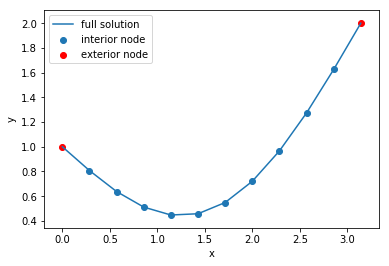

In [24]:
plt.plot(x, y_full, label='full solution')
plt.scatter(x[1:-1], y_interior, label='interior node')
plt.scatter(x[0], y_LHS, color='r', label='exterior node')
plt.scatter(x[-1], y_RHS, color='r')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

---

# 2 Discretising derivatives into banded matrices

Let's work with the example below.

$$\frac{d^2y}{dt^2} + \frac{dy}{dt} + y = 0$$

Over the interval $t \in [0,30]$ with boundary conditions $y(t=0)=10$ and $y(t=30)=0$.

Which we need to get in the form:
$$\mathbf{M}\mathbf{y}=\mathbf{a}$$


## 2.1 Right hand side

$$\frac{d^2y}{dt^2} + \frac{dy}{dt} + y = 0$$

The RHS $\mathbf{a}$ is just a vector of length $N$ where, in this case, all the elements are equal to 0.

In [ ]:
# Assuming 10 nodes:
N=10

a = np.zeros(N)

print(a)

## 2.2 Left hand side

$$\frac{d^2y}{dt^2} + \frac{dy}{dt} + y = 0$$


What we want to do is be able to describe the left hand side in a discretised form spread across $N$ nodes:
$$\mathbf{M}.\mathbf{y}$$

Where

$$\mathbf{y} = \begin{pmatrix}
y_{1}\\
\vdots \\
    y_{n-1}\\
    y_{n}\\
    y_{n+1}\\
    \vdots\\
    y_{N}\\
    \end{pmatrix}$$

and $\mathbf{M}$ is an $N \times N$ square matrix.

Since this is a linear problem, we can just create a matrix for each of the three terms and then add them together elementwise.


## 2.2a The $y_n$ term in $\frac{d^2y}{dt^2} + \frac{dy}{dt} + y = 0$


The simplest term on the LHS is the one that is not a derivative, it is just $y$.

$$y(x_n) = y_{n}$$


The identity matrix dotted with a vector just returns that vector. 

Which can be represented by the banded matrix:

$$
\begin{pmatrix}
\vdots & & & & &  \\
 & 0 & 1 & 0 & & \\
 & & 0 & 1 & 0  & \\
 &  & & 0 & 1 & 0   \\
 & & \dots &  &  &    \\
\end{pmatrix}\cdot
\begin{pmatrix}
\vdots \\
    y_{n-1}\\
    y_{n}\\
    y_{n+1}\\
    \vdots\\
    \end{pmatrix} $$

We need to define the number of interior points, `N` and the step size `h`.

Let's look at how to create this identity matrix.

- Since there are lots of zeros, we will use the sparse representation to save memory.

In [6]:
## Some useful functions for creating banded matrices to describe derivatives

from scipy import sparse
import scipy.sparse.linalg as linalg   # linear algebra for sparse systems
    
def returnDiagonalMatrixFor_y(N):
    M_forY = sparse.eye(N,N,0)
    return M_forY

Let's see what this matrix looks like by printing it.
- we can convert is to  a dense martix using the `.todense()` method

In [ ]:
N=10

print( "This is a full matrix:" )
print( returnDiagonalMatrixFor_y(N).todense() )
print( "" )
print( "Let's print is as a sparse matrix:" )
print( returnDiagonalMatrixFor_y(N) )

And we can visualise it by plotting it using `plt.matshow()` to plot the matrix:

In [5]:
print( "" )
print( "Let's plot it:" )
plt.matshow( returnDiagonalMatrixFor_y(N).todense() )
plt.colorbar()

This is a full matrix:
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

Let's print is as a sparse matrix:
  (0, 0)	1.0
  (1, 1)	1.0
  (2, 2)	1.0
  (3, 3)	1.0
  (4, 4)	1.0
  (5, 5)	1.0
  (6, 6)	1.0
  (7, 7)	1.0
  (8, 8)	1.0
  (9, 9)	1.0

Let's plot it:


NameError: name 'plt' is not defined

## 2.2b The first order derivative term in $\frac{d^2y}{dt^2} + \frac{dy}{dt} + y = 0$

Let's look at how to discretise a 1st order derivative symmetrically about a point.
- This is identical to how we calculated the gradient of Arthur's Seat in Week 3.


Using the central difference approximation

$$\frac{dy(x_n)}{dx} \approx \frac{y_{n+1}-y_{n-1}}{2h}$$

Which can be represented by the banded matrix:


$$
\frac{1}{2h}
\begin{pmatrix}
\vdots & & & & &  \\
 & -1 & 0 & 1 & & \\
 & & -1 & 0 & 1  & \\
 &  & & -1 & 0 & 1   \\
 & & \dots &  &  &    \\
\end{pmatrix}\cdot
\begin{pmatrix}
\vdots \\
    y_{n-1}\\
    y_{n}\\
    y_{n+1}\\
    \vdots\\
    \end{pmatrix} $$
    
    
<div class="alert alert-block alert-info"> **IMPORTANT:** Convince yourself that when you multiply out each row you recover a term like:

$$ \frac{y_{n+1}-y_{n-1}}{2h} $$

but centered on a different position.
</div>

In [ ]:
def createFirstOrderDiffMatrix_dy_dx(N, h):
    M_FirstOrderTerm = ( sparse.eye(N,N,1) - sparse.eye(N,N,-1) ) / (2*h)
    return M_FirstOrderTerm

[[ 0.   0.5  0.   0.   0.   0.   0.   0.   0.   0. ]
 [-0.5  0.   0.5  0.   0.   0.   0.   0.   0.   0. ]
 [ 0.  -0.5  0.   0.5  0.   0.   0.   0.   0.   0. ]
 [ 0.   0.  -0.5  0.   0.5  0.   0.   0.   0.   0. ]
 [ 0.   0.   0.  -0.5  0.   0.5  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.  -0.5  0.   0.5  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.  -0.5  0.   0.5  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.  -0.5  0.   0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.  -0.5  0.   0.5]
 [ 0.   0.   0.   0.   0.   0.   0.   0.  -0.5  0. ]]


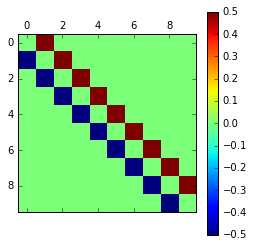

In [9]:
N=10   # Number of nodes
h=1    # Step size

print( createFirstOrderDiffMatrix_dy_dx(N, h).todense() )

plt.matshow( createFirstOrderDiffMatrix_dy_dx(N, h).todense() )
plt.colorbar()

## 2.2c The second order derivative term in $\frac{d^2y}{dt^2} + \frac{dy}{dt} + y = 0$

Starting with a central difference approximation for the gradient centered on a point midway between two nodes:

$$\frac{dy(x_{n+1/2})}{dx} \approx \frac{y_{n+1}-y_{n}}{h}$$

We can discretise a 2nd order derivative symmetrically about a node using the rate of change in the derivatives at the midpoints either side of the node:

$$\frac{d^2y(x_n)}{dx^2} \approx \frac{ \frac{dy(x_{n+1/2})}{dx} - \frac{dy(x_{n-1/2})}{dx}}{h}\approx \frac{ \frac{y_{n+1}-y_{n}}{h} - \frac{y_{n}-y_{n-1}}{h}}{h} = \frac{y_{n+1}-2y_{n}+y_{n-1}}{h^2}$$

Which can be represented by the banded matrix:

$$
\frac{1}{h^2}
\begin{pmatrix}
\vdots & & & & &  \\
 & 1 & -2 & 1 & & \\
 & & 1 & -2 & 1  & \\
 &  & & 1 & -2 & 1   \\
 & & \dots &  &  &    \\
\end{pmatrix}\cdot
\begin{pmatrix}
\vdots \\
    y_{n-1}\\
    y_{n}\\
    y_{n+1}\\
    \vdots\\
    \end{pmatrix} $$
    
    
<div class="alert alert-block alert-info"> **IMPORTANT:** Convince yourself that when you multiply out each row you recover an equation like:

$$ \frac{y_{n+1}-2y_n+y_{n-1}}{h^2} $$

but centered on a different position.
</div>

In [7]:
def createSecondOrderDiffMatrix_d2y_dx2(N, h):
    M_SecondOrderTerm = ( -2*sparse.eye(N,N,0) + sparse.eye(N,N,1) + sparse.eye(N,N,-1) ) / h**2
    return M_SecondOrderTerm

In [10]:
N=10
h=1

print( createSecondOrderDiffMatrix_d2y_dx2(N, h).todense() )

plt.matshow( createSecondOrderDiffMatrix_d2y_dx2(N, h).todense() )
plt.colorbar()

[[-2.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -2.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. -2.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -2.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1. -2.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -2.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1. -2.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1. -2.]]


## 2.3 Let's combine these elements and solve the problem

$$\frac{d^2y}{dt^2} + \frac{dy}{dt} + y = 0$$

Over the interval $t \in [0,30]$ with $y(t=0)=0$ and $y(t=30)=0$.

In [20]:
L = 30.
N=300        # Number of interior nodes
h=L/(N+2)

# Create matrices of the interior nodes
#M = createSecondOrderDiffMatrix_d2y_dx2(N, h) + createFirstOrderDiffMatrix_dy_dx(N, h) + returnDiagonalMatrixFor_y(N) 
M = createSecondOrderDiffMatrix_d2y_dx2(N, h) + createFirstOrderDiffMatrix_dy_dx(N, h) + returnDiagonalMatrixFor_y(N) 

a = np.zeros(N)

plt.matshow( M.todense() )
plt.colorbar()

We now have a banded martix representation of $\frac{d^2y}{dt^2} + \frac{dy}{dt} + y = 0$

- Each row corresponds to a separate equation in a set of `N` simultaneous equations.
- The interior nodes are the ones in the middle
- The only things affecting these nodes are the values of $y$ the adjacent nodes
- When the matrix is solved it makes sure that each of the simultanous equations is satified at each node
   - Which in turn means the controlling physics that underlies the differentiation equation is also satisfied

We ALSO need to think about the boundary conditions
- This is how we make sure the __boundary values at either end of the system are satisfied__.
- Remember, the point of this was to solve boundary value ODEs!

## 2.4 Imposing the boundary conditions


### Case 1: Diriclet Boundary Conditions: BC is a value of $y$

Let's start by discretising the ODE:

$$\frac{d^2y}{dt^2} + \frac{dy}{dt} + y = 0$$

becomes

$$\frac{y_{n+1}-2y_n+y_{n-1}}{h^2} + \frac{y_{n+1}-y_{n-1}}{2h} + y_n = 0$$

Let's group like terms:

$$y_{n+1} \left( \frac{1}{h^2}+\frac{1}{2h} \right) + y_n \left( 1-\frac{2}{h^2} \right) +  y_{n-1} \left( \frac{1}{h^2}-\frac{1}{2h} \right)   = 1$$


#### (1) Impose boundary condition $y(x=0)=10$:

At the top the discretised equation looks like:

$$y_{2} \left( \frac{1}{h^2}+\frac{1}{2h} \right) + y_1 \left( 1-\frac{2}{h^2} \right)    = - y_{0} \left( \frac{1}{h^2}-\frac{1}{2h} \right)$$

- The LHS of this equation corresponds to the top row of the matrix
- So, we need to subtract $y_{0} \left( \frac{1}{h^2}-\frac{1}{2h} \right)$ where $y(t=0)=y_0=10$ from the top row of `a` to satisfy this BC

In [21]:
y0 = 10
a[0] -= y0 * ( 1/(h*h) - (2*h))

#### (2) Impose boundary condition $y(x=30)=0$:

At the bottom, the discretised equation looks like:

$$ y_n \left( 1-\frac{2}{h^2} \right) + y_{n-1} \left( \frac{1}{h^2}-\frac{1}{2h} \right)   = -y_{n+1} \left( \frac{1}{h^2}+\frac{1}{2h} \right) $$


- The LHS of this equation corresponds to the bottom row of the matrix
- So, we need to subtract $y_{n+1} \left( \frac{1}{h^2}+\frac{1}{2h} \right)$ where $y(t=30)=0$ from the bottom row of `a` to satisfy this BC

In [22]:
yf=0
a[-1] -= yf * ( 1/(h*h) + (2*h))

#### Solve the matrix and plot the result

- $\mathbf{M}$ give the discretised differential equation
- $\mathbf{a}$ gives the RHS of the differential equation AND is corrected to impose the BCs

We can now solve: $\mathbf{M.y}=\mathbf{a}$

for the interior nodes $\mathbf{y}$ using `linlag.solve()`


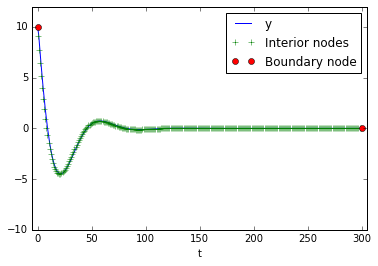

In [23]:
# Solve for the interior nodes
y = linalg.spsolve(M,a)

# Append on the boundary nodes
y_full = np.append(y0,y)
y_full = np.append(y_full,yf)

# Plot the solution
plt.plot(y_full, label="y")
plt.plot(y,'+', label="Interior nodes")
plt.plot(0,10,'o', c='r')
plt.plot(300,0,'o', c='r', label="Boundary node")
plt.xlim(-5,305)
plt.ylim(-10,12)
plt.xlabel("t")
plt.legend()


### Case 2: Neuman Boundary Condition: BC is the gradient of $y$

Solve $$\frac{d^2y}{dt^2} + \frac{dy}{dt} + y = 0$$

Over the interval $t \in [0,30]$ with boundary conditions $\dot{y}(t=0)=0.2$ and $y(t=30)=0$.

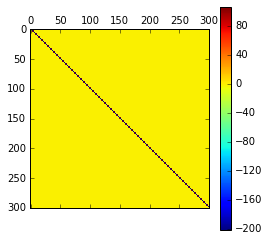

In [24]:
# As before

L = 30.
N=300        # Number of interior nodes
h=L/(N+2)

# Create matrices of the interior nodes
M = createSecondOrderDiffMatrix_d2y_dx2(N, h) + createFirstOrderDiffMatrix_dy_dx(N, h) + returnDiagonalMatrixFor_y(N) 

a = np.zeros(N)


plt.matshow( M.todense() )
plt.colorbar()

Let's think about boundary conditions a bit more

- Dirichlet: Value given at boundary
- Neumann: Value of derivative given at boundary

#### (1) Impose boundary condition $\dot{y}(x=0)=1/2$:

The discretised equation about the first node is:


$$y_{2} \left( \frac{1}{h^2}+\frac{1}{2h} \right) + y_1 \left( 1-\frac{2}{h^2} \right)    = - y_{0} \left( \frac{1}{h^2}-\frac{1}{2h} \right)$$

This time, we do not know a value for $y_0$, but something about it's derivative:

$$\frac{y_1-y_0}{h}=0.2$$


$$y_{2} \left( \frac{1}{h^2}+\frac{1}{2h} \right) + y_1 \left( 1-\frac{2}{h^2} \right)    =  - (y_{1}-0.2 h) \left( \frac{1}{h^2}-\frac{1}{2h} \right)$$


$$y_{2} \left( \frac{1}{h^2}+\frac{1}{2h} \right) + y_1 \left( 1-\frac{2}{h^2} \right)    + \left[ y_{1} \left( \frac{1}{h^2}-\frac{1}{2h} \right) \right]=  \left[ 0.2 h \left( \frac{1}{h^2}-\frac{1}{2h} \right) \right]$$





- So, we need to correct the matrix by adding $\left( \frac{1}{h^2}-\frac{1}{2h} \right)$ from the `M[0,0]` element
- AND, we need to subtract $0.2 h \left( \frac{1}{h^2}-\frac{1}{2h} \right) $ from `a[0]` to correct the RHS.

In [25]:
dy0_dx = 0.2

M[0,0] += (1/(h**2) - 1/(2*h))
a[0] += dy0_dx*(1/(h) - 1/2)

The far boundary condition is unchanged

In [26]:
yf=0
a[-1] -= yf * ( 1/(h*h) + (2*h))

Solve and plot as before

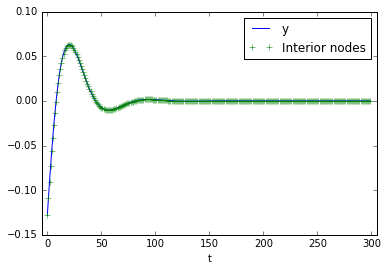

In [27]:
# Solve for the interior nodes
y = linalg.spsolve(M,a)

# Plot the solution
plt.plot(y, label="y")
plt.plot(y,'+', label="Interior nodes")
plt.xlim(-5,305)

plt.xlabel("t")
plt.legend()

# EXERCISES

## 3.1 EXERCISE  Solve $ \frac{d^2y}{dx^2}=x\sin x \quad y(0)=y(\pi)=1 $

$$ \frac{y_{n+1}-2y_n+y_{n-1}}{h^2}=x_n \sin x_n $$

With boundary conditions $y_0=y_{N-1}=0$ and $h=\pi/(N-1)$

This can be written as a matrix-vector equation away from the boundaries:

$$
\frac{1}{h^2}
\begin{pmatrix}
\vdots & & & & \huge0&  \\
 & 1 & -2 & 1 & & \\
 & & 1 & -2 & 1  & \\
 & \huge0 & & 1 & -2 & 1   \\
 & & \dots &  &  &    \\
\end{pmatrix}
\cdot
\begin{pmatrix}
\vdots \\
    y_{n-1}\\
    y_{n}\\
    y_{n+1}\\
    \vdots\\
    \end{pmatrix}  
= \begin{pmatrix}
      \vdots \\
    x_{n-1} \sin x_{n-1}\\
    x_{n} \sin x_{n}\\
    x_{n+1} \sin x_{n+1}\\
    \vdots\\
    \end{pmatrix}
$$

<div class="alert alert-block alert-info"> **IMPORTANT:** Convince yourself that when you multiply out each row you recover an equation like:

$$ \frac{y_{n+1}-2y_n+y_{n-1}}{h^2}=x_n \sin x_n $$

but centered on a different position.
</div>

<div class="alert alert-block alert-info">
**NOTE:** This problem is of the form,
$$\mathbf{M}\mathbf{y} = \mathbf{f}$$

<br>Where we know $\mathbf{M}$, $\mathbf{f}$ and want to solve for $\mathbf{y}$.

<br>This is a standard martix problem we can solve using `scipy.linalg.solve()` if we can construct $\mathbf{M}$ and $\mathbf{f}$.
</div>



### Generate the Matrix

In [ ]:
### Complete Code Below
# Number of interior nodes to use
N = 100

# Create spatial array over whole domain
x = np.linspace( ... , ... , N+2)

# Calculate the grid spacing
h= ...

# Create matrix
M = ...

In [33]:
### ANSWER
# Number of interior nodes to use
N = 100

# Create spatial array over whole domain
x = np.linspace(0,np.pi,N+2)

# Calculate the grid spacing
h=x[1]-x[0]

# Create matrix
M = createSecondOrderDiffMatrix_d2y_dx2(N, h)

### Generate the RHS

In [34]:
## Complete code below

x_interior = x[ ... : ... ]
a = x_interior * np.sin( x_interior )

In [ ]:
## ANSWER

x_interior = x[1:-1]
a = x_interior * np.sin( x_interior )

### Apply the BCs
The discretised equations is:

$$\frac{y_{n+1}-2y_n+y_{n-1}}{h^2}  = x_n \sin(x_n)$$

#### At the first node:

$$\frac{y_{2}-2y_1+y_{0}}{h^2}  = x_1 \sin(x_1)$$

$$\frac{y_{2}-2y_1}{h^2}  = x_1 \sin(x_1)- \frac{y_{0}}{h^2}$$

And, $$ y_0 = 1 $$

Therefore, we need to subtract $1/h^2$ from `a[0]`

In [ ]:
# Complete code below

y0 = ...

a[0] = a[0] - ...

In [35]:
## ANSWER 

y0 = 0

a[0] -= y0/h**2

#### At the last node

$$\frac{y_{n+1}-2y_n+y_{n-1}}{h^2}  = x_1 \sin(x_1)$$

$$\frac{-2y_1+y_{0}y_{n-1}}{h^2}  = x_1 \sin(x_1)- \frac{y_{n+1}}{h^2}$$

And, $$ y_{n+1} = 1 $$

Therefore, we need to subtract $1/h^2$ from `a[-1]`

In [36]:
# Complete code below

yf = ...

a[-1] = a[-1] - ...

In [ ]:
## ANSWER

yf = 1

a[-1] -= yf/h**2

Solve and plot

In [ ]:
## Complete code below

y_interior = linalg.spsolve( ... , ... )

y_full = np.append( ... , ... )
y_full = np.append( ... , ... )

In [ ]:
## ANSWER

y_interior = linalg.spsolve(M,a)

y_full = np.append( y0, y_interior )
y_full = np.append( y_full, yf )

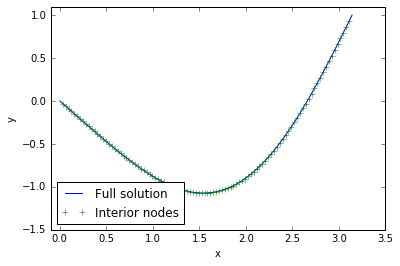

In [37]:
plt.plot(x,y_full, label="Full solution")
plt.scatter(x_interior,y_interior,'+', label="Interior nodes")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-0.1,3.5)
plt.ylim(-1.5,1.1)
plt.legend(loc="lower left")

---

## EXERCISE 3.2: Use banded matrices to solve $ \frac{d^2y}{dx^2}+4\frac{dy}{dx}-y=\cos x $ with $y(0)=y(\pi)=1$

<div class="alert alert-block alert-success"> ANSWER

### (i) Discretise about the $k^{th}$ node

$$
\overbrace{\frac{y_{k+1}- 2y_k +y_{k-1}}{h^2}}^{\frac{d^2y}{dx^2}}
+4\overbrace{\frac{y_{k+1}- y_{k-1}}{2h}}^{\frac{dy}{dx}}
-y_k=\cos x_k
$$

</div>


In [ ]:
## MODIFY THE CODE BELOW

N = 30
x  = np.linspace( ... ,  ... , N+2) ## To include the BCs we add 2 more points
h =  ... 

M_SecondOrderTerm = createSecondOrderDiffMatrix_d2y_dx2(N, h)
M_FirstOrderTerm =  ... 
M_subtractY =  ... 

M =  ...  +  ...  *  ...  +  ... 

In [ ]:
## ANSWER

N = 30
x  = np.linspace(0, np.pi, N+2) ## To include the BCs we add 2 more points
h = x[1]-x[0]

M_SecondOrderTerm = createSecondOrderDiffMatrix_d2y_dx2(N, h)
M_FirstOrderTerm = createFirstOrderDiffMatrix_dy_dx(N, h)
M_subtractY = -returnDiagonalMatrixFor_y(N)

M = M_SecondOrderTerm + 4* M_FirstOrderTerm + M_subtractY

<div class="alert alert-block alert-success">

### (iii) Construct the RHS forcing term $f(x) = \cos x$

This is over the full range of the solution $x \in [0,\pi]$.

</div>

In [ ]:
## ANSWER

x_interior = x[1:-1]

f = np.cos(x_interior) ## The forcing terms on the RHS

plt.plot(x_interior,f)
plt.xlabel("x")
plt.ylabel("The boundary condition $f(x)=cos(x)$")

<div class="alert alert-block alert-success">

### (iv) Apply Boundary Conditions
</div>

#### For 1st node

$$
\frac{y_{k+1}- 2y_k +y_{k-1}}{h^2}
+4\frac{y_{k+1}- y_{k-1}}{2h} 
-y_k=\cos x_k
$$


$$
\frac{y_{2}- 2y_1 +y_{0}}{h^2}
+4\frac{y_{2}- y_{0}}{2h} 
-y_1=\cos x_1
$$


$$
\frac{y_{2}- 2y_1 }{h^2}  
 + 2\frac{y_{2}}{h} -y_1+ y_0\left[\frac{1}{h^2}-2\frac{ 1}{h} \right]
=\cos x_1
$$


$$
\frac{y_{2}- 2y_1 }{h^2}  
 + 2\frac{y_{2}}{h} -y_1
=\cos x_1 - y_0\left[\frac{1}{h^2}-2\frac{ 1}{h} \right]
$$

Since $y_0 = 1$, we need to subtract $\left[\frac{1}{h^2}-2\frac{ 1}{h} \right]$ from `f[0]` for this problem

In [ ]:
y0 = 1

f[0] -= y0*( 1/h**2 - 2/h )

#### For last node

$$
\frac{y_{k+1}- 2y_k +y_{k-1}}{h^2}
+4\frac{y_{k+1}- y_{k-1}}{2h} 
-y_k=\cos x_k
$$


$$
\frac{y_{n+1}- 2y_n +y_{n-1}}{h^2}
+2\frac{y_{n+1}- y_{n-1}}{h} 
-y_n=\cos x_n
$$




$$
\frac{y_{n+1}}{h^2} + \frac{- 2y_n +y_{n-1}}{h^2}
+2\frac{y_{n+1}}{h} - 2\frac{y_{n-1}}{h} 
-y_n=\cos x_n
$$


$$
 \frac{- 2y_n +y_{n-1}}{h^2}
-y_n +y_{n+1}\left[ \frac{1}{h^2} + 2\frac{1}{h} \right]=\cos x_n 
$$


$$
 \frac{- 2y_n +y_{n-1}}{h^2} -y_n =\cos x_n -y_{n+1}\left[ \frac{1}{h^2} + 2\frac{1}{h} \right]
$$

Since $y_{n+1}=1$ in this example, we need to subtract $\left[ \frac{1}{h^2} + 2\frac{1}{h} \right]$ from  `f[-1]`

In [ ]:
yf = 1
f[-1] -= yf*(1/h**2 + 2/h)

<div class="alert alert-block alert-success">

### (v) Solve the matrix equation

And now use a sparse matrix solver to solve the matrix equation $\mathbf{My}=\mathbf{f}$ for $\mathbf{y}$

</div>

In [ ]:
## ANSWER

# Use the linalg function for sparce matrices to solve My=x for y
y = linalg.spsolve(M,f)

print( "The number of nodes along x = ", np.shape(x))
print( "The number of nodes in the solution = ", np.shape(y))

## This solution was for the interior nodes so we need to addon the BCs
y_full = np.append(y0, y)
y_full = np.append(y_full, yf)

print( "The number of nodes in y when we add the 2 BCs = ", np.shape(y))

<div class="alert alert-block alert-success">

### (vi) Plot the solution

</div>

In [ ]:
## ANSWER


plt.plot(x,y_full,'kd', label='y') # plot numerical solnplt.title('Banded Diagonal Soln')
plt.xlabel('X')
plt.ylabel('Y')

import fractions  ## This module allows us to plot the x axis labels as fractions
yy=np.arange(0,1.25,0.25)
labels=[str(fractions.Fraction(x))+r"$\pi$" for x in yy.tolist()]
plt.xticks(yy*np.pi,labels)

plt.legend()

print ("Python solution to d^2y/dx^2 + 4 dy/dx -y = cos(x)")

## EXERCISE 3.3: Use banded matrices to solve $y''+4y=0$ where $y(0)=1$ and $y'(\pi)=2$

Solve $y''+4y=0$ using the boundary conditions
$y(0)=1$ and $y'(\pi)=2$. 

Compare your answer to the one you obtained using the shooting method

